In [1]:
import torch
import torch.nn.functional as F
import numpy as np

from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm

from dataloader import *

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Setting random seed for consistent behavior
import random
train_seed = 72 - 3
random.seed(train_seed)
torch.manual_seed(train_seed)
torch.cuda.manual_seed(train_seed)
torch.backends.cudnn.deterministic = True
random.seed(train_seed)
np.random.seed(train_seed)

# Environment & Data Configuration

In [2]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 9
#batch_size = 16        # Note: in og CML trajectory length == batch_size; in POCML this should be decoupled
n_obs = 9
trajectory_length = 12  # numer of node visits in a trajectory
num_desired_trajectories= 20

# choose env from "random", "small world" or "dead ends"
# TODO devouple batch_size from trajectory length for GraphEnv
# env = GraphEnv(n_nodes=n_nodes, n_items=n_obs, env='regular', action_type = "regular", batch_size=trajectory_length, num_desired_trajectories=num_desired_trajectories, unique = True)

env = GraphEnv( n_items=n_nodes,                     # number of possible observations
                env='grid', 
                batch_size=trajectory_length, 
                num_desired_trajectories=num_desired_trajectories, 
                device=None, 
                unique=True,                         # each state is assigned a unique observation if true
                args = {"rows": 3, "cols": 3}
            )

#dataset = RandomWalkDataset(env.adj_matrix, trajectory_length, num_desired_trajectories, n_obs, env.items)
train_dataset = env.dataset.data

env.gen_dataset()
test_dataset = env.dataset.data

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

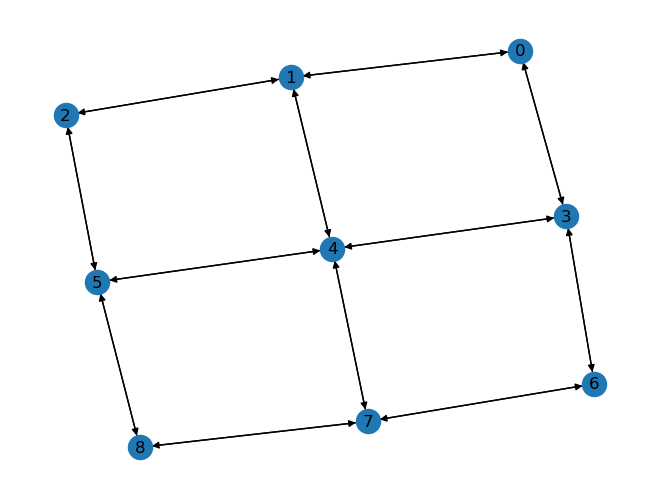

number of actions: 4
Sample trajectory:
tensor([[[6, 3, 7],
         [7, 2, 6],
         [6, 0, 3],
         [3, 1, 6],
         [6, 0, 3],
         [3, 0, 0],
         [0, 1, 3],
         [3, 1, 6],
         [6, 0, 3],
         [3, 3, 4],
         [4, 3, 5]]])
S-O mapping:
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
action-to-node:
{1: tensor([5, 8]), 3: tensor([7, 8]), 2: tensor([8, 7]), 0: tensor([8, 5])}
node-to-action-matrix:
tensor([[-1,  3, -1,  1, -1, -1, -1, -1, -1],
        [ 2, -1,  3, -1,  1, -1, -1, -1, -1],
        [-1,  2, -1, -1, -1,  1, -1, -1, -1],
        [ 0, -1, -1, -1,  3, -1,  1, -1, -1],
        [-1,  0, -1,  2, -1,  3, -1,  1, -1],
        [-1, -1,  0, -1,  2, -1, -1, -1,  1],
        [-1, -1, -1,  0, -1, -1, -1,  3, -1],
        [-1, -1, -1, -1,  0, -1,  2, -1,  3],
        [-1, -1, -1, -1, -1,  0, -1,  2, -1]])
affordance / node - to action:
{0: tensor([1, 3]), 1: tensor([1, 2, 3]), 2: tensor([1, 2]), 3: tensor([0, 1, 3]), 4: tensor([0, 1, 2, 3]), 5: tensor([0, 1, 2]

In [3]:
adj = env.adj_matrix

# Assuming you have the adjacency matrix stored in the variable "adj"
G = nx.from_numpy_array(adj.numpy().astype(float), create_using = nx.DiGraph)

# Draw the graph using seaborn
# sns.set()
seed = 31 # Consistent graph shape across runs
pos = nx.spring_layout(G, seed=seed)
nx.draw(G, pos = pos, with_labels=True)
# Show the plot
plt.show()

print(f"number of actions: {env.n_actions}")

print("Sample trajectory:")
for trajectory in train_dataloader:
    print(trajectory)
    break

print("S-O mapping:")
print(env.items)
print("action-to-node:")
print(env.action_to_node)
print("node-to-action-matrix:")
print(env.node_to_action_matrix)
print("affordance / node - to action:")
print(env.affordance)

# Model & Trainer Config 

In [4]:
# Our code
from trainer import POCMLTrainer
from model import POCML, sim

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dim = 500
random_feature_dim = 5000
epochs = 10

model = POCML(
    n_obs = env.n_items,
    n_states = env.size,
    n_actions = env.n_actions,
    state_dim = state_dim,
    random_feature_dim = random_feature_dim,
    alpha = 1,
    beta_obs = 8,
    beta_state = 8,
    memory_bypass=False,
    mem_reweight_rate = "adaptive", 
    decay = "adaptive"
)
    
trainer = POCMLTrainer(
    model=model, 
    train_loader = train_dataloader,
    lr_Q_o = 0.1, 
    lr_V_o = 0.01, 
    lr_Q_s = 0., 
    lr_V_s = 0., 
    lr_all = 1,
    normalize = False,
    reset_every=4,
    refactor_memory=True
)

loss_record = np.array(trainer.train(epochs)).reshape(epochs,-1)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Current Trajectory tensor([[4, 3, 5],
        [5, 1, 8],
        [8, 2, 7],
        [7, 0, 4],
        [4, 1, 7],
        [7, 2, 6],
        [6, 0, 3],
        [3, 0, 0],
        [0, 3, 1],
        [1, 1, 4],
        [4, 0, 1]])
initial state: tensor(4)
Print initial score tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
Obs similarity
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Action difference
 tensor([[0.0000, 1.5331, 1.3754, 1.3868],
        [1.5331, 0.0000, 1.4636, 1.4097],
        [1.3754, 1.4636, 0.0000, 1.4387],
        [1.3868, 1.4097, 1.4387, 0.0000]])
State  difference
 tensor([[0.0000, 1.4089, 1.4087, 1.4030, 1.

In [5]:
print("State similarities:\n", model.get_state_similarities())
print("Action similarities:\n", model.get_action_similarities())

State similarities:
 tensor([[ 0.9488, -0.0259,  0.0551, -0.0141, -0.0102, -0.0286, -0.0706, -0.0101,
         -0.0333],
        [-0.0259,  0.9231,  0.1037, -0.0600, -0.0174,  0.0502, -0.0534,  0.0477,
          0.0188],
        [ 0.0551,  0.1037,  1.1009, -0.0285, -0.0934, -0.0320,  0.0493,  0.0264,
         -0.0412],
        [-0.0141, -0.0600, -0.0285,  0.8992,  0.0510, -0.0081, -0.0247,  0.0412,
          0.0144],
        [-0.0102, -0.0174, -0.0934,  0.0510,  0.9877,  0.0438, -0.0332,  0.0657,
         -0.0027],
        [-0.0286,  0.0502, -0.0320, -0.0081,  0.0438,  1.0376, -0.0091,  0.0801,
          0.0295],
        [-0.0706, -0.0534,  0.0493, -0.0247, -0.0332, -0.0091,  0.9563,  0.0251,
          0.0808],
        [-0.0101,  0.0477,  0.0264,  0.0412,  0.0657,  0.0801,  0.0251,  1.0155,
         -0.0190],
        [-0.0333,  0.0188, -0.0412,  0.0144, -0.0027,  0.0295,  0.0808, -0.0190,
          0.9491]])
Action similarities:
 tensor([[ 1.1021, -0.1079,  0.1180,  0.0693],
        [-

In [6]:
phi_Q = model.get_state_kernel()
phi_V = model.get_action_kernel()
print("State kernel similarities:\n", sim(phi_Q.T, phi_Q.T))
print("Action kernel similarities:\n", sim(phi_V.T, phi_V.T))

State kernel similarities:
 tensor([[1.0000, 0.3638, 0.3811, 0.3827, 0.3715, 0.3504, 0.3429, 0.3713, 0.3719],
        [0.3638, 1.0000, 0.3952, 0.3831, 0.3775, 0.3950, 0.3721, 0.3880, 0.3951],
        [0.3811, 0.3952, 1.0000, 0.3527, 0.3263, 0.3285, 0.3837, 0.3625, 0.3467],
        [0.3827, 0.3831, 0.3527, 1.0000, 0.4230, 0.3695, 0.3904, 0.4016, 0.4033],
        [0.3715, 0.3775, 0.3263, 0.4230, 1.0000, 0.3698, 0.3728, 0.3956, 0.3817],
        [0.3504, 0.3950, 0.3285, 0.3695, 0.3698, 1.0000, 0.3649, 0.3834, 0.3739],
        [0.3429, 0.3721, 0.3837, 0.3904, 0.3728, 0.3649, 1.0000, 0.3851, 0.4223],
        [0.3713, 0.3880, 0.3625, 0.4016, 0.3956, 0.3834, 0.3851, 1.0000, 0.3593],
        [0.3719, 0.3951, 0.3467, 0.4033, 0.3817, 0.3739, 0.4223, 0.3593, 1.0000]])
Action kernel similarities:
 tensor([[1.0000, 0.2843, 0.3850, 0.3694],
        [0.2843, 1.0000, 0.3455, 0.3597],
        [0.3850, 0.3455, 1.0000, 0.3589],
        [0.3694, 0.3597, 0.3589, 1.0000]])


In [ ]:
# beta_obs, beta_state, clean up rate
torch.save(model.state_dict(), "model/model_12_12_1.ckpt")

In [7]:
import evaluate

train_acc, train_confidences = evaluate.accuracy(model, train_dataloader)
print("Train obs accuracy/confidence:", train_acc, np.mean(train_confidences))

test_acc, test_confidences = evaluate.accuracy(model, test_dataloader)
print("Test obs accuracy/confidence:", test_acc, np.mean(test_confidences))

sa_acc, sa_confidences, sa_distance_ratios = evaluate.state_transition_consistency(model, env)
print("State-action accuracy/confidence/distance ratio:", sa_acc, np.mean(sa_confidences), np.mean(sa_distance_ratios))

Train obs accuracy/confidence: 0.10909090909090909 0.10916198646141724
Test obs accuracy/confidence: 0.1318181818181818 0.11321839100935242
State-action accuracy/confidence/distance ratio: 0.0 0.03716588819709917 1.2365795424990154


In [8]:
from sklearn.manifold import MDS

def visualize(distances, legend:str ="Node"):
    mds = MDS(n_components =2)
    positions = mds.fit_transform(distances)

    plt.figure(figsize=(8, 6))
    plt.scatter(positions[:, 0], positions[:, 1])

    # Optional: Annotate the points
    for i, (x, y) in enumerate(positions):
        plt.text(x, y, f'{legend} {i}', fontsize=12)

    plt.title('Graph Visualization using MDS')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()

/Users/calvin/miniforge3/envs/pytorch/lib/python3.12/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


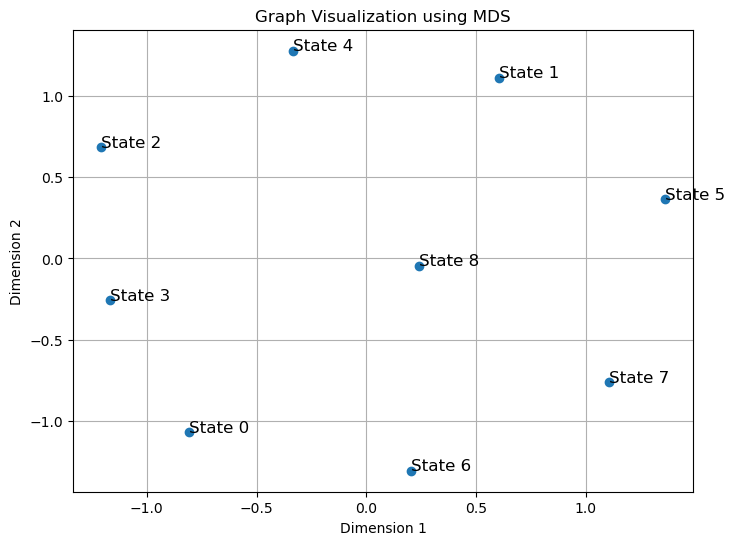

In [9]:
visualize(model.get_state_differences().numpy(), legend = "State")

/Users/calvin/miniforge3/envs/pytorch/lib/python3.12/site-packages/sklearn/manifold/_mds.py:626: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


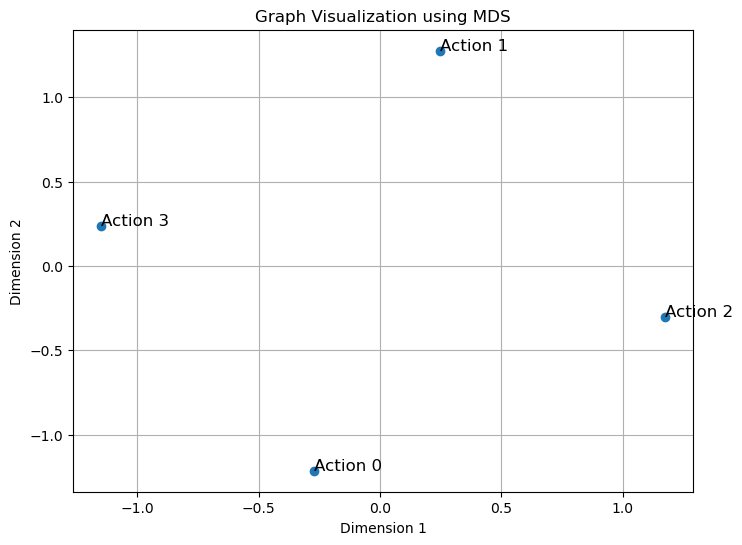

In [10]:
visualize(model.get_action_differences().numpy(), "Action")

Text(0.5, 0, 'Epochs')

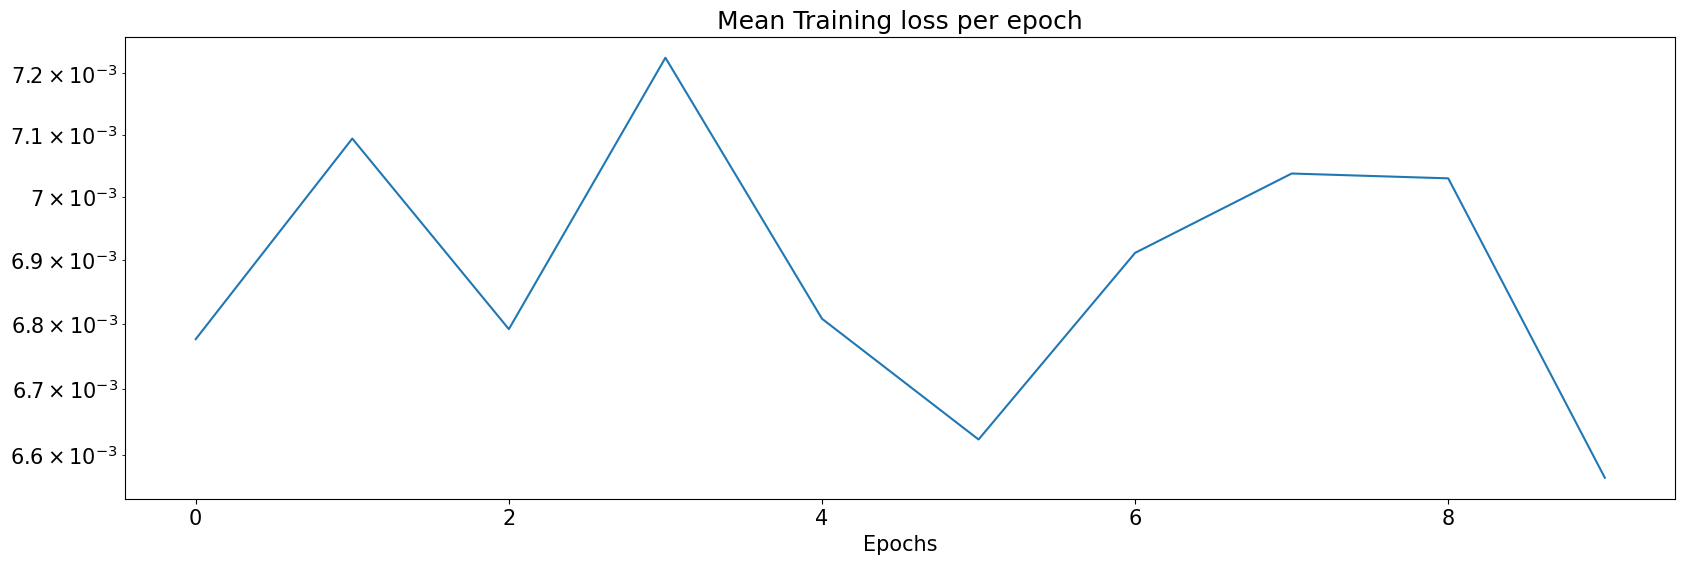

In [11]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(np.mean(loss_record, axis=1)/(env.num_desired_trajectories * (env.batch_size-1) ))
plt.yscale('log')
plt.title('Mean Training loss per epoch') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


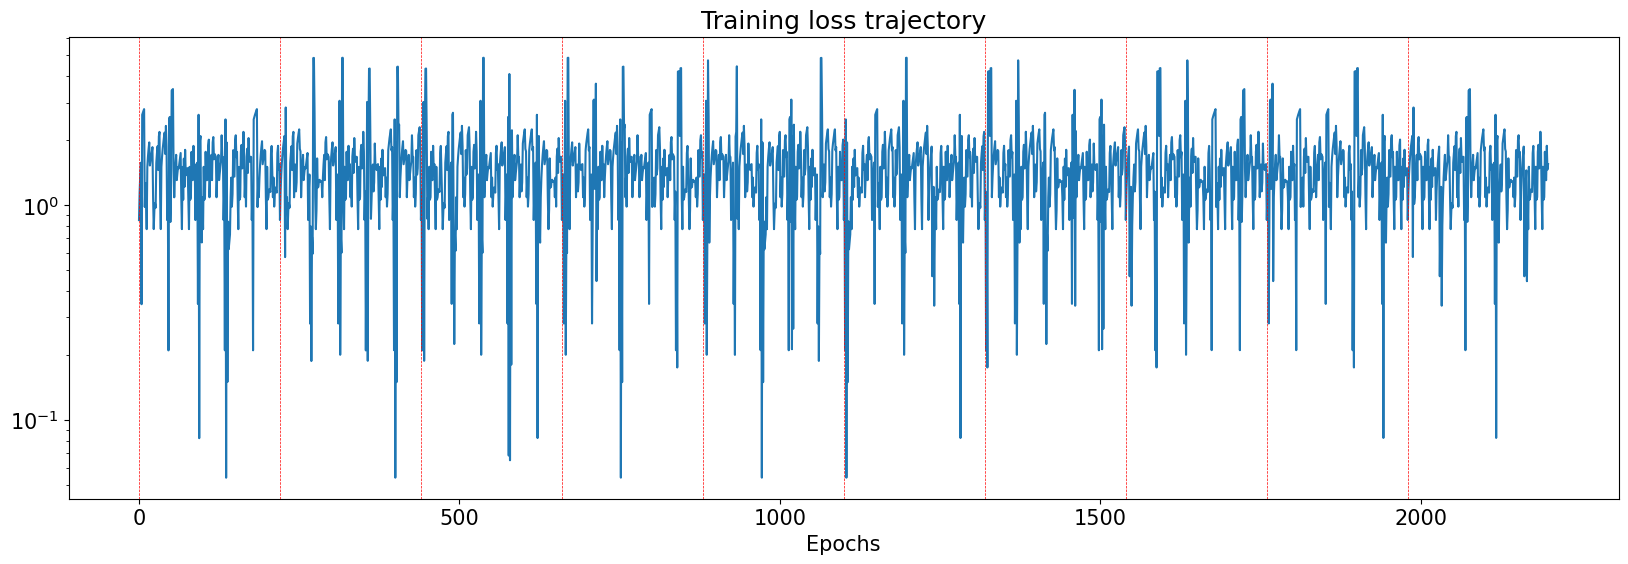

In [12]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(loss_record.reshape(-1))
plt.yscale('log')
plt.title('Training loss trajectory') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

# Get the current y-ticks
yticks = plt.yticks()[0]

print(yticks)

# Add vertical lines at each multiple of 5

for i in range(0, len(loss_record.reshape(-1)), num_desired_trajectories * (trajectory_length-1)):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.5)



In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            #steps, o_record = model.plan(start_idx, goal_idx, env, False)
            steps = model.plan(state, affordance=None):

        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:
# CML's model

def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_matrix(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 